Install neccessary packages 

In [1]:
%pip install pandas 
%pip install numpy  
%pip install ipywidgets  
%pip install matplotlib 
%pip install seaborn  
%pip install sklearn 
%pip install pyarrow


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # this is needed for the parquet file
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [3]:
if os.path.exists('./Data'):
    print('Data folder exists')

if os.path.exists('./Data/Bus'):
    print('Bus Data folder exists')
else:
    os.makedirs('./Data/Bus')

if os.path.exists('./Data/MetEirrean/'):
    print('Weather data folder exists')
else:
    os.makedirs('./Data/MetEirrean/')

if os.path.exists('./Zips/MetEirrean'):
    print('Weather folder exisits')
else:
    os.makedirs('./Zips/MetEirrean/')



Data folder exists
Bus Data folder exists
Weather data folder exists
Weather folder exisits


Download the Dublin Bus data from https://data.gov.ie/organization/dublin-city-council?tags=Transport+and+Infrastructure

Use a generator to load the data into pandas data frame https://pandasninja.com/2019/04/how-to-read-lots-of-csv-files-easily-into-pandas/#:~:text=How%20to%20read%20lots%20of%20csv%20files%20easily,need%20...%204%204.%20Leverage%20regular%20expressions%20


In [4]:
# Function to load the Dublin bus gz files 
def load_Files(direc, files, comtype):
    columns = ['Timestamp', 'LineID', 'Direction', 'JourneyPatternID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'LonWGS84', 'LatWGS84', 'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
    for f in files:
        print(f)
        yield pd.read_csv(direc + f, compression=comtype, delimiter=',', header=0, names=columns, parse_dates=True, low_memory=True)

def crackit_open(busFile):
    import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
    with zip.ZipFile(busFile,  mode='r') as arc: 
        arc.extractall('./Data/Bus/Gz/')  
    files = os.listdir('./Data/Bus/Gz/')
    DBfiles = [f for f in files if f.endswith('.gz')]
    df = pd.concat(load_Files('./Data/Bus/Gz/', DBfiles, 'gzip'), copy = False)
    return df

In [5]:

# Check parquet file existence before downloading - iof starting from afresh this takes a long time
if os.path.exists('./Data/Bus/CleanedBusData.parquet'):
    print("Parquest file exists, means the Bus data has been downloaded already ")
    df = pd.read_parquet('./Data/Bus/CleanedBusData.parquet')
elif os.path.exists('./Zips/Bus/DublinBusdata.zip'):
    print("Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open")
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')
else:
    os.makedirs('./Zips/Bus/', exist_ok = True)
    url = "https://opendata.dublincity.ie/TrafficOpenData/sir010113-310113.zip"
    busFile = rq.urlretrieve(url, './Zips/Bus/DublinBusdata.zip' )  
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')



Parquest file exists, means the Bus data has been downloaded already 


In [6]:

def dropcols_func(df,ColumnsToExclude):
# Data is loaded - now needs to be cleaned, there is an argument to be made to include this in the above cell 
# but I have added it here so that I can add more columns to be excluded as I go rather than load the raw data each time
    for c in ColumnsToExclude:
        if c in df.columns:  # type: ignore
            df = df.drop(c, axis=1)  # type: ignore
        else:
            print('Columns already dropped')
    return df

ColumnsToExclude = ('JourneyPatternID', 'StopID', 'Direction')
dropcols_func(df, ColumnsToExclude)




Columns already dropped
Columns already dropped
Columns already dropped


,Timestamp,LineID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time,Day,Hour,Minute
0,1356998405000000,27.0,2012-12-31,3883,RD,0,-6.233417,53.342232,0,27017,33521,0,2013-01-01 00:00:05,00:00:05,1,0,0
1,1356998407000000,40.0,2012-12-31,2226,HN,0,-6.278250,53.416683,0,40206,33142,0,2013-01-01 00:00:07,00:00:07,1,0,0
2,1356998407000000,7.0,2012-12-31,6106,D1,0,-6.231633,53.317768,0,7019,43004,1,2013-01-01 00:00:07,00:00:07,1,0,0
3,1356998411000000,747.0,2012-12-31,3531,SL,0,-6.254617,53.355484,-454,747007,40039,0,2013-01-01 00:00:11,00:00:11,1,0,0
4,1356998411000000,56.0,2012-12-31,1830,RD,0,-6.233183,53.342201,0,56001,33488,0,2013-01-01 00:00:11,00:00:11,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603915,1359632694000000,39.0,2013-01-31,3247,PO,0,-6.410302,53.390999,128,39021,36046,0,2013-01-31 11:44:54,11:44:54,31,11,44
603916,1359632694000000,9.0,2013-01-31,3649,PO,0,-6.266890,53.389503,118,9008,33437,0,2013-01-31 11:44:54,11:44:54,31,11,44
603917,1359632694000000,41.0,2013-01-31,112,HN,0,-6.244456,53.398102,-186,822010,33221,0,2013-01-31 11:44:54,11:44:54,31,11,44
603918,1359632694000000,145.0,2013-01-31,6810,D1,0,-6.256400,53.335468,192,821387,33542,1,2013-01-31 11:44:54,11:44:54,31,11,44


In [7]:
df.head()

,Timestamp,LineID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time,Day,Hour,Minute
0,1356998405000000,27.0,2012-12-31,3883,RD,0,-6.233417,53.342232,0,27017,33521,0,2013-01-01 00:00:05,00:00:05,1,0,0
1,1356998407000000,40.0,2012-12-31,2226,HN,0,-6.278250,53.416683,0,40206,33142,0,2013-01-01 00:00:07,00:00:07,1,0,0
2,1356998407000000,7.0,2012-12-31,6106,D1,0,-6.231633,53.317768,0,7019,43004,1,2013-01-01 00:00:07,00:00:07,1,0,0
3,1356998411000000,747.0,2012-12-31,3531,SL,0,-6.254617,53.355484,-454,747007,40039,0,2013-01-01 00:00:11,00:00:11,1,0,0
4,1356998411000000,56.0,2012-12-31,1830,RD,0,-6.233183,53.342201,0,56001,33488,0,2013-01-01 00:00:11,00:00:11,1,0,0


In [9]:
# Deal with the timestamp and make it human readable and i will use this to merge datasets later
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='us')
df['Time'] = df['datetime'].dt.time
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Minute'] = df['datetime'].dt.minute
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['DayofWeek'] = df['datetime'].dt.day_of_week

In [10]:
df.head()

,Timestamp,LineID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time,Day,Hour,Minute,Year,Month
0,1356998405000000,27.0,2012-12-31,3883,RD,0,-6.233417,53.342232,0,27017,33521,0,2013-01-01 00:00:05,00:00:05,1,0,0,2013,1
1,1356998407000000,40.0,2012-12-31,2226,HN,0,-6.278250,53.416683,0,40206,33142,0,2013-01-01 00:00:07,00:00:07,1,0,0,2013,1
2,1356998407000000,7.0,2012-12-31,6106,D1,0,-6.231633,53.317768,0,7019,43004,1,2013-01-01 00:00:07,00:00:07,1,0,0,2013,1
3,1356998411000000,747.0,2012-12-31,3531,SL,0,-6.254617,53.355484,-454,747007,40039,0,2013-01-01 00:00:11,00:00:11,1,0,0,2013,1
4,1356998411000000,56.0,2012-12-31,1830,RD,0,-6.233183,53.342201,0,56001,33488,0,2013-01-01 00:00:11,00:00:11,1,0,0,2013,1


In [11]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))
print("The types of columns are:")
df.dtypes

The data has 44455102 Rows and 19 columns
The types of columns are:


Timestamp                    int64
LineID                     float64
TimeFrame                   object
VehicleJourneyID             int64
Operator                    object
Congestion                   int64
LonWGS84                   float64
LatWGS84                   float64
Delay                        int64
BlockID                      int64
VehicleID                    int64
AtStop                       int64
datetime            datetime64[ns]
Time                        object
Day                          int64
Hour                         int64
Minute                       int64
Year                         int64
Month                        int64
dtype: object

In [12]:
df.describe()


,Timestamp,LineID,VehicleJourneyID,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,Day,Hour,Minute,Year,Month
count,4.445510e+07,4.445304e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,44455102.0,44455102.0
mean,1.358318e+15,7.796879e+01,9.417122e+03,1.163261e-02,-6.272803e+00,5.334513e+01,-2.816513e+01,1.092438e+05,3.542925e+04,2.335773e-01,1.567200e+01,1.388824e+01,2.946709e+01,2013.0,1.0
std,7.394928e+11,1.146419e+02,6.159844e+04,1.072254e-01,8.389025e-02,5.488354e-02,4.729678e+02,1.921244e+05,3.281093e+03,4.231063e-01,8.563509e+00,4.921598e+00,1.729008e+01,0.0,0.0
min,1.356998e+15,1.000000e+00,1.000000e+00,0.000000e+00,-6.617517e+00,5.306802e+01,-1.504500e+04,3.900000e+02,2.804700e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2013.0,1.0
25%,1.357679e+15,2.500000e+01,2.536000e+03,0.000000e+00,-6.308650e+00,5.332005e+01,-2.090000e+02,1.602000e+04,3.330800e+04,0.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,2013.0,1.0
50%,1.358327e+15,4.000000e+01,4.718000e+03,0.000000e+00,-6.261600e+00,5.334645e+01,0.000000e+00,4.020500e+04,3.352500e+04,0.000000e+00,1.600000e+01,1.400000e+01,2.900000e+01,2013.0,1.0
75%,1.358955e+15,8.300000e+01,6.769000e+03,0.000000e+00,-6.233166e+00,5.337533e+01,1.040000e+02,8.400400e+04,3.802500e+04,0.000000e+00,2.300000e+01,1.800000e+01,4.400000e+01,2013.0,1.0
max,1.359633e+15,7.470000e+02,9.998560e+05,1.000000e+00,-6.052917e+00,5.360873e+01,1.161220e+05,8.350020e+05,4.307800e+04,1.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,2013.0,1.0


In [13]:
# Getting the list of column Types
CategoricalColumns = list(set(['LineID', 'Direction', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion',  'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']))
NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))
#objectTypeColumns = list(set(list(df.select_dtypes([np.object_]).columns)))
DateColumns = list(set(list(df.select_dtypes([np.datetime64]).columns)))


#print(objectTypeColumns)


CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude)-set(DateColumns))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude)-set(DateColumns))

print(CategoricalColumns)
print(NumericalColumns)
print(DateColumns)


['VehicleID', 'VehicleJourneyID', 'Delay', 'AtStop', 'LineID', 'BlockID', 'Operator', 'Congestion', 'TimeFrame']
['LatWGS84', 'VehicleID', 'VehicleJourneyID', 'Year', 'Hour', 'Delay', 'AtStop', 'LineID', 'BlockID', 'Congestion', 'Month', 'LonWGS84', 'Timestamp', 'Minute', 'Day']
['datetime']


In [14]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

In [15]:


temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']  # type: ignore
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType'] # type: ignore

In [16]:
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)


In [17]:
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
Timestamp,44455102.0,1.358318e+15,7.394928e+11,1.356998e+15,1.357679e+15,1.358327e+15,1.358955e+15,1.359633e+15,0,813103,int64
LineID,44453044.0,7.796879e+01,1.146419e+02,1.000000e+00,2.500000e+01,4.000000e+01,8.300000e+01,7.470000e+02,2058,67,float64
VehicleJourneyID,44455102.0,9.417122e+03,6.159844e+04,1.000000e+00,2.536000e+03,4.718000e+03,6.769000e+03,9.998560e+05,0,18614,int64
Congestion,44455102.0,1.163261e-02,1.072254e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0,2,int64
LonWGS84,44455102.0,-6.272803e+00,8.389025e-02,-6.617517e+00,-6.308650e+00,-6.261600e+00,-6.233166e+00,-6.052917e+00,0,456755,float64
LatWGS84,44455102.0,5.334513e+01,5.488354e-02,5.306802e+01,5.332005e+01,5.334645e+01,5.337533e+01,5.360873e+01,0,131327,float64
Delay,44455102.0,-2.816513e+01,4.729678e+02,-1.504500e+04,-2.090000e+02,0.000000e+00,1.040000e+02,1.161220e+05,0,12638,int64
BlockID,44455102.0,1.092438e+05,1.921244e+05,3.900000e+02,1.602000e+04,4.020500e+04,8.400400e+04,8.350020e+05,0,1238,int64
VehicleID,44455102.0,3.542925e+04,3.281093e+03,2.804700e+04,3.330800e+04,3.352500e+04,3.802500e+04,4.307800e+04,0,911,int64
AtStop,44455102.0,2.335773e-01,4.231063e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0,2,int64


col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
print(summary_df_cat)

We can see from the Correlation matrix that none of the variables in the Bus data is correlated to either Delay or Congestion variables

In [18]:
c_df = df.corr('pearson', numeric_only=True)



<AxesSubplot:>

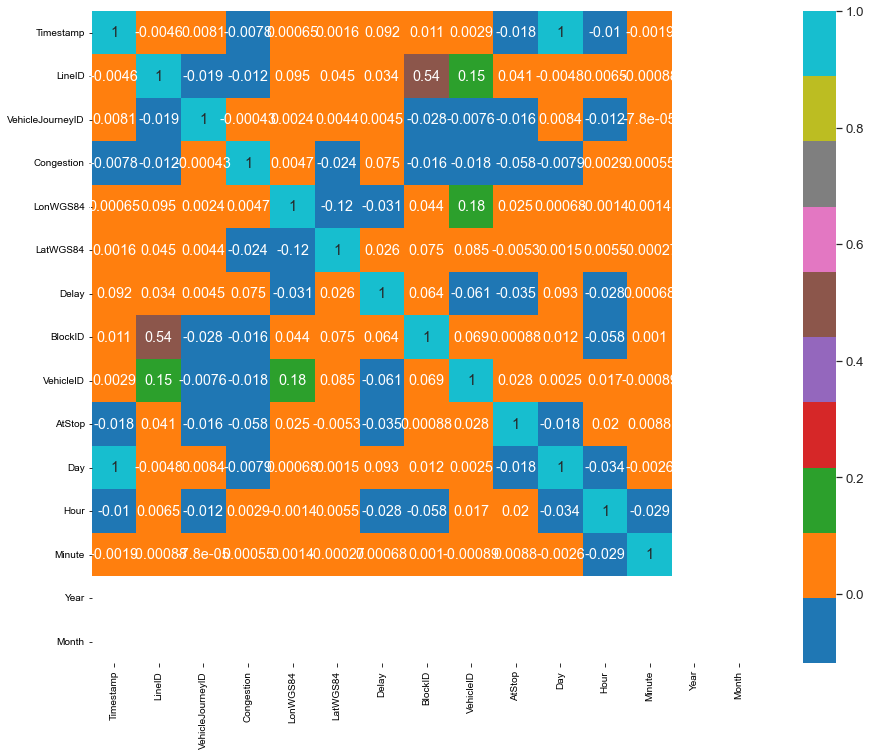

In [19]:
fig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="tab10", annot=True)

In [20]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44455102 entries, 0 to 603919
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         int64         
 1   LineID            float64       
 2   TimeFrame         object        
 3   VehicleJourneyID  int64         
 4   Operator          object        
 5   Congestion        int64         
 6   LonWGS84          float64       
 7   LatWGS84          float64       
 8   Delay             int64         
 9   BlockID           int64         
 10  VehicleID         int64         
 11  AtStop            int64         
 12  datetime          datetime64[ns]
 13  Time              object        
 14  Day               int64         
 15  Hour              int64         
 16  Minute            int64         
 17  Year              int64         
 18  Month             int64         
dtypes: datetime64[ns](1), float64(3), int64(12), object(3)
memory usage: 6.6+ GB


In [21]:
%matplotlib inline
sns.set(color_codes=True)
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
603915    False
603916    False
603917    False
603918    False
603919    False
Length: 44455102, dtype: bool

<AxesSubplot:xlabel='Delay'>

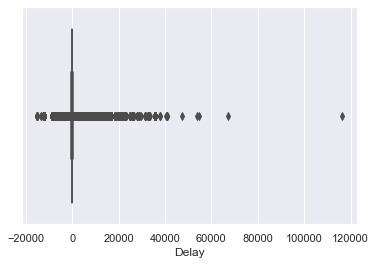

In [22]:
sns.boxplot(x=df['Delay'])

In [38]:
busRoutes = df['LineID'].unique()

busRoutes

array([ 27.,  40.,   7., 747.,  56.,  25.,   4., 272.,  83., 130.,  13.,
        46.,  66.,  41.,  65.,  15., 151.,  39., 122.,  16., 150.,  33.,
       145.,  29., 123.,  37., 271.,  67.,  14.,  38.,  84.,  18.,  31.,
        59., 171.,   9., 332.,  11.,  42.,  54.,  49., 120., 104.,  44.,
        75.,  68.,  63., 140.,   1., 102.,  76., 451.,  79., 238., 220.,
        17.,  53., 331.,  nan, 114., 142.,  51.,  32., 111., 116., 118.,
        86.])

In [39]:
dates = df['datetime'].unique()
dates

array(['2013-01-01T00:00:05.000000000', '2013-01-01T00:00:07.000000000',
       '2013-01-01T00:00:11.000000000', ...,
       '2013-01-31T11:44:29.000000000', '2013-01-31T11:44:40.000000000',
       '2013-01-31T11:44:54.000000000'], dtype='datetime64[ns]')

array([[<AxesSubplot:title={'center':'Congestion'}>]], dtype=object)

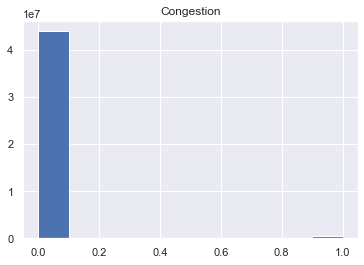

In [40]:
df.hist('Congestion')

array([[<AxesSubplot:title={'center':'Delay'}>]], dtype=object)

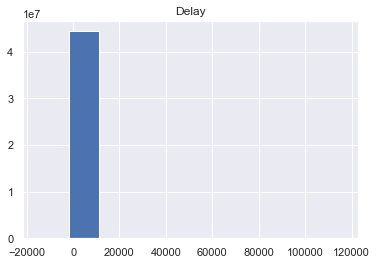

In [41]:
df.hist('Delay')

array([[<AxesSubplot:title={'center':'LineID'}>]], dtype=object)

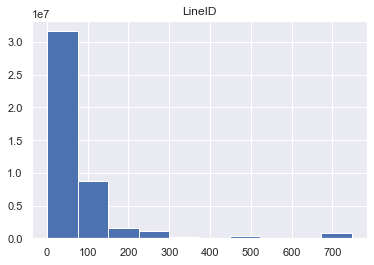

In [42]:
df.hist('LineID')

In [43]:
dfnan = df[df["LineID"].isna()]
dfnan.head()

,Timestamp,LineID,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time,Day,Hour,Minute,Year,Month
606776,1357070530000000,NaN,2013-01-01,11755,CD,0,-6.468083,53.336235,0,25014,33190,0,2013-01-01 20:02:10,20:02:10,1,20,2,2013,1
607031,1357070548000000,NaN,2013-01-01,11755,CD,0,-6.468083,53.336235,0,25014,33190,0,2013-01-01 20:02:28,20:02:28,1,20,2,2013,1
607292,1357070569000000,NaN,2013-01-01,11755,CD,0,-6.468083,53.336250,0,25014,33190,0,2013-01-01 20:02:49,20:02:49,1,20,2,2013,1
607623,1357070589000000,NaN,2013-01-01,11755,CD,0,-6.468083,53.336235,0,25014,33190,0,2013-01-01 20:03:09,20:03:09,1,20,3,2013,1
607898,1357070610000000,NaN,2013-01-01,11755,CD,0,-6.468083,53.336235,0,25014,33190,0,2013-01-01 20:03:30,20:03:30,1,20,3,2013,1


In [44]:
dfnan.shape

(2058, 19)

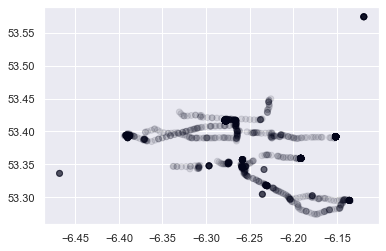

In [45]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(x=dfnan['LonWGS84'], y=dfnan['LatWGS84'], alpha=0.1, c=dfnan['Delay'] );

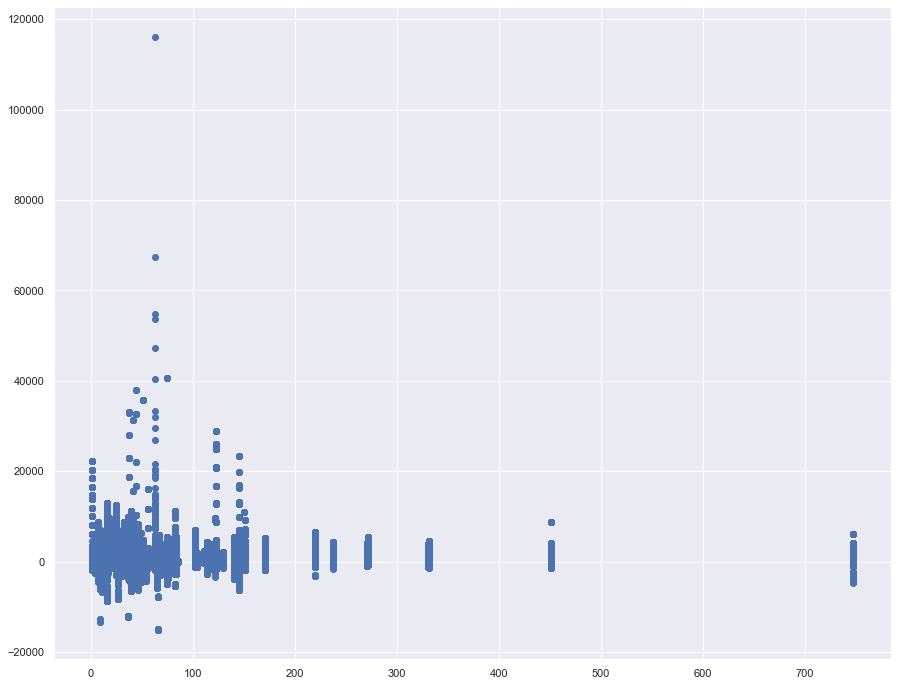

In [48]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['LineID'],df['Delay'])
plt.show()

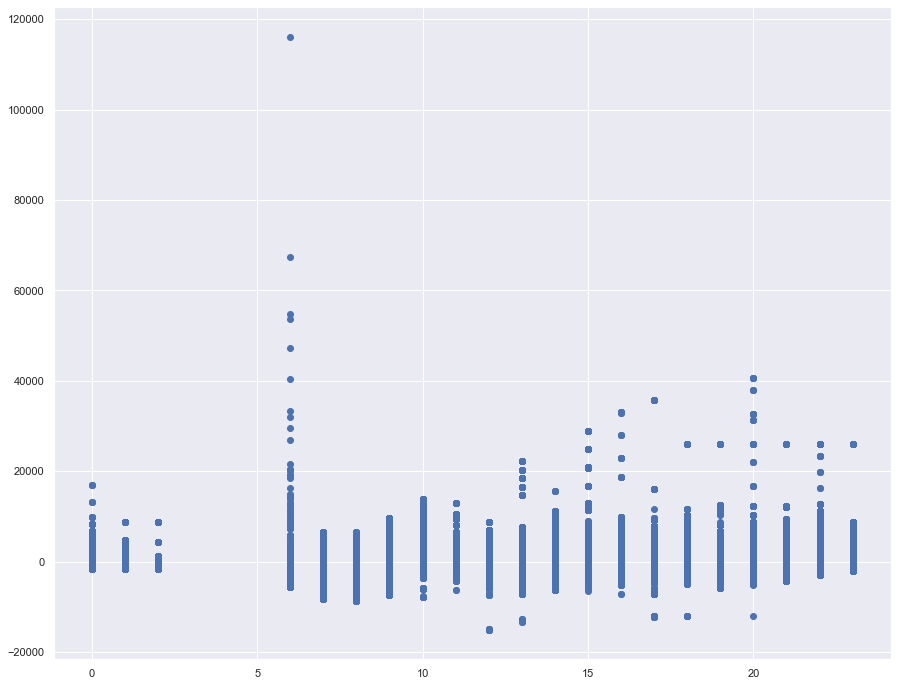

In [49]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Hour'],df['Delay'])
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Day'],df['Delay'])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['DayofWeek'],df['Delay'])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Hour'],df['Congestion'])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['DayofWeek'],df['Congestion'])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Day'],df['Congestion'])
plt.show()

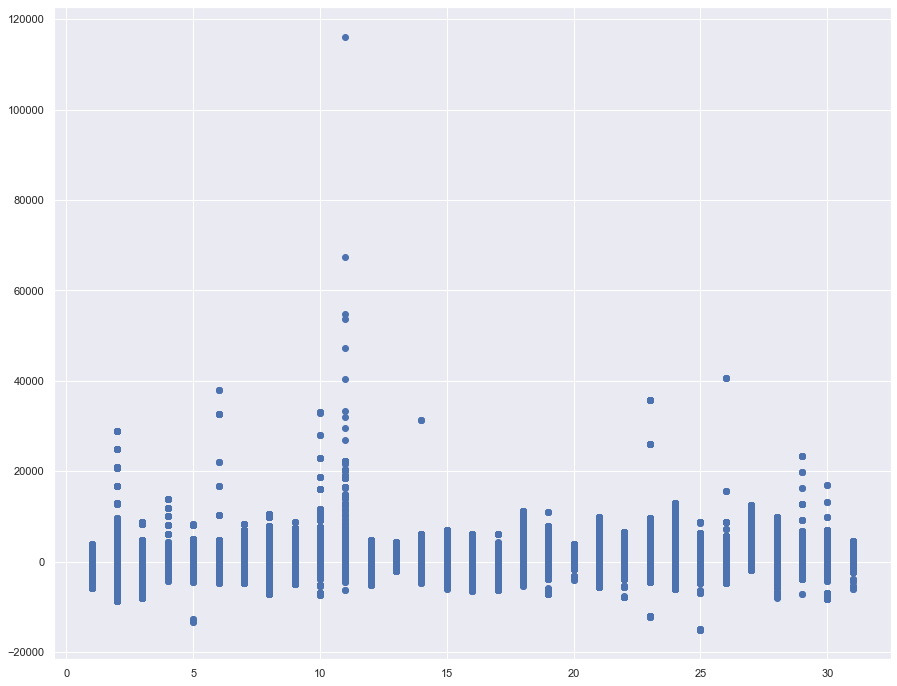

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['LineID'],df['Congestion'])
plt.show()

In [50]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['LonWGS84'], df['LatWGS84'], df['Hour'], c=df['Delay'] )
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Hour')
plt.show()


Download the weather station details https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv

In [ ]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv'


Load the weather statio details for Dublin

In [ ]:
weatherStations = pd.read_csv(url)
weatherStations = weatherStations[weatherStations['county'].str.contains('Dublin')]
weatherStations.head(10)

,county,station name,name,height(m),easting,northing,latitude,longitude,open year,close year
575,Dublin,10323,STILLORGAN (FARMLEIGH),67,320514,227230,53.28194,-6.19389,1915,1935
576,Dublin,10123,DUBLIN (FITZWILLIAM SQUARE),16,316404,233098,53.33556,-6.25333,1908,1937
577,Dublin,10223,ROYAL BOTANIC GARDENS (GLASNEVIN,17,315083,237179,53.37250,-6.27167,1880,1925
578,Dublin,1223,BELGARD CASTLE,125,307400,229300,53.30278,-6.38889,1914,1963
579,Dublin,632,LUSK G.S.,23,321700,254300,53.52500,-6.16528,1949,2012
580,Dublin,1232,KINSALEY (AGR.RES.STN.),19,321500,242900,53.42222,-6.17222,1961,2004
581,Dublin,2523,DUBLIN (Ringsend),7,318900,233900,53.34167,-6.21389,1911,(null)
582,Dublin,2623,HOWTH CASTLE,11,327900,239000,53.38611,-6.07778,1913,1971
583,Dublin,2723,STILLORGAN (VARTRY HSE.),80,320200,226800,53.27778,-6.19722,1915,1999
584,Dublin,2732,ARDGILLAN,62,321791,261102,53.58583,-6.16167,1894,1938


In [ ]:
dublinStations = weatherStations[["station name", "name"]]

#why do this? 
temp_df = dublinStations.describe().T
missing_df = pd.DataFrame(dublinStations.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore
unq_df = pd.DataFrame(dublinStations.apply(num_unique, axis=0))
unq_df.columns = ['unique']  # type: ignore
types_df = pd.DataFrame(dublinStations.dtypes)
types_df.columns = ['DataType']  # type: ignore
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
print(summary_df)

              count         mean          std    min      25%     50%     75%  \
station name   94.0  4237.542553  3086.169009  124.0  1554.75  3473.5  6773.0   

                  max  missing  unique DataType  
station name  10323.0        0      94    int64  


In [ ]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in dublinStations[["name"]]:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
print(summary_df_cat)  # there are 2 stations named DUBLIN (Glasnevin)

      missing  unique DataType
name        0      93   object


In [ ]:
list(types_df.index)

['station name', 'name']

In [ ]:
dublinStations.columns = [x.strip().replace(' ', '') for x in dublinStations.columns]


<bound method NDFrame.describe of      stationname                              name
575        10323            STILLORGAN (FARMLEIGH)
576        10123       DUBLIN (FITZWILLIAM SQUARE)
577        10223  ROYAL BOTANIC GARDENS (GLASNEVIN
578         1223                    BELGARD CASTLE
579          632                         LUSK G.S.
..           ...                               ...
664         9623       KNOCKLYON (ST.COLUMCILLE'S)
665         9723                 Dublin-Navan_Road
666          623                           BRITTAS
667         9823           DUBLIN (MERRION SQUARE)
668         2423                 DUBLIN (CLONTARF)

[94 rows x 2 columns]>

In [ ]:
for rows in dublinStations.itertuples():
    # get hourly weather data
    url = "http://cli.fusio.net/cli/climate_data/webdata/hly" + str(rows.stationname) + ".zip"
    print(url)
    dest = './Zips/MetEirrean/hly' + str(rows.stationname) + ".zip"
    try:
        weatherFile = rq.urlretrieve(url, dest)
        continue
    except Exception:
        print('No file exists')  
    # # get the daily weather data - ONLY USING THE HOURLY DATA FOR NOW
    # url = "http://cli.fusio.net/cli/climate_data/webdata/dly" + str(rows.stationname) + ".zip"
    # print(url)
    # dest = './Zips/MetEirrean/dly' + str(rows.stationname) + ".zip"
    # try:
    #     weatherFile = rq.urlretrieve(url, dest)
    #     continue
    # except Exception:
    #     print('No file exists')  

http://cli.fusio.net/cli/climate_data/webdata/hly10323.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly10123.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly10223.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1223.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly632.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1232.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2523.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2623.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2723.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2732.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1323.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2823.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1332.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly

In [ ]:
import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
files = os.listdir('./Zips/MetEirrean/')
WDfiles = [f for f in files if f.startswith('hly')]
for f in WDfiles:
    fp = './Zips/MetEirrean/' + f
    with zip.ZipFile(fp,  mode='r') as arc: 
        arc.extractall('./Data/MetEirrean/')



In [ ]:
files = os.listdir('./Data/MetEirrean/')  
WDfiles = [f for f in files if f.endswith('.csv')] # need to remove the empty files

In [ ]:
def load_csv_Files(direc, files):

    for f in files:
        # need to get number of rows to skip 
        temp=pd.read_csv(direc + f,sep='^',header=None,prefix='X')
        temp2=temp.X0.str.split(',',expand=True)
        del temp['X0']
        temp=pd.concat([temp,temp2],axis=1)
        cols = list(range(0,temp.shape[1]))

        print(f)
        yield pd.read_csv(direc + f,  delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, usecols=cols, na_values='NAN')
    

In [32]:
Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')

Phoenix_wdf['datetime'] = pd.to_datetime(Phoenix_wdf['date'])
Phoenix_wdf['Year'] = Phoenix_wdf['datetime'].dt.year
Phoenix_wdf['Month'] = Phoenix_wdf['datetime'].dt.month
Phoenix_wdf['Day'] = Phoenix_wdf['datetime'].dt.day
Phoenix_wdf['Time'] = Phoenix_wdf['datetime'].dt.time
Phoenix_wdf['Hour'] = Phoenix_wdf['datetime'].dt.hour
Phoenix_wdf['Minute'] = Phoenix_wdf['datetime'].dt.minute
Phoenix_wdf['DayofWeek'] = Phoenix_wdf['datetime'].dt.day_of_week
#Filter the weather data to January 2013
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Year'] == 2013]
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Month'] == 1]
Phoenix_wdf = Phoenix_wdf.astype({"rain": float})
Phoenix_wdf = Phoenix_wdf.astype({"temp": float})
Phoenix_wdf = Phoenix_wdf.astype({"wetb": float})
Phoenix_wdf = Phoenix_wdf.astype({"dewpt": float})
Phoenix_wdf = Phoenix_wdf.astype({"vappr": float})
Phoenix_wdf = Phoenix_wdf.astype({"rhum": float})
Phoenix_wdf = Phoenix_wdf.astype({"msl": float})


Phoenix_wdf.dtypes

C:\Users\stehayes\AppData\Local\Temp\ipykernel_18772\652057656.py:1: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')


date                 object
ind                   int64
rain                float64
ind.1                 int64
temp                float64
ind.2                 int64
wetb                float64
dewpt               float64
vappr               float64
rhum                float64
msl                 float64
datetime     datetime64[ns]
Year                  int64
Month                 int64
Day                   int64
Time                 object
Hour                  int64
Minute                int64
DayofWeek             int64
dtype: object

In [33]:
ColumnsToExclude = ('ind', 'ind.1', 'ind.2')
Phoenix_wdf = dropcols_func(Phoenix_wdf, ColumnsToExclude)
Phoenix_wdf.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,datetime,Year,Month,Day,Time,Hour,Minute,DayofWeek
82223,01-jan-2013 00:00,0.0,3.1,2.4,1.4,6.8,88.0,1000.2,2013-01-01 00:00:00,2013,1,1,00:00:00,0,0,1
82224,01-jan-2013 01:00,0.0,3.3,2.5,1.2,6.6,85.0,1000.8,2013-01-01 01:00:00,2013,1,1,01:00:00,1,0,1
82225,01-jan-2013 02:00,0.0,2.9,2.2,1.2,6.7,88.0,1001.2,2013-01-01 02:00:00,2013,1,1,02:00:00,2,0,1
82226,01-jan-2013 03:00,0.0,2.7,2.1,1.1,6.6,89.0,1001.8,2013-01-01 03:00:00,2013,1,1,03:00:00,3,0,1
82227,01-jan-2013 04:00,0.1,2.5,1.9,1.0,6.6,90.0,1002.5,2013-01-01 04:00:00,2013,1,1,04:00:00,4,0,1


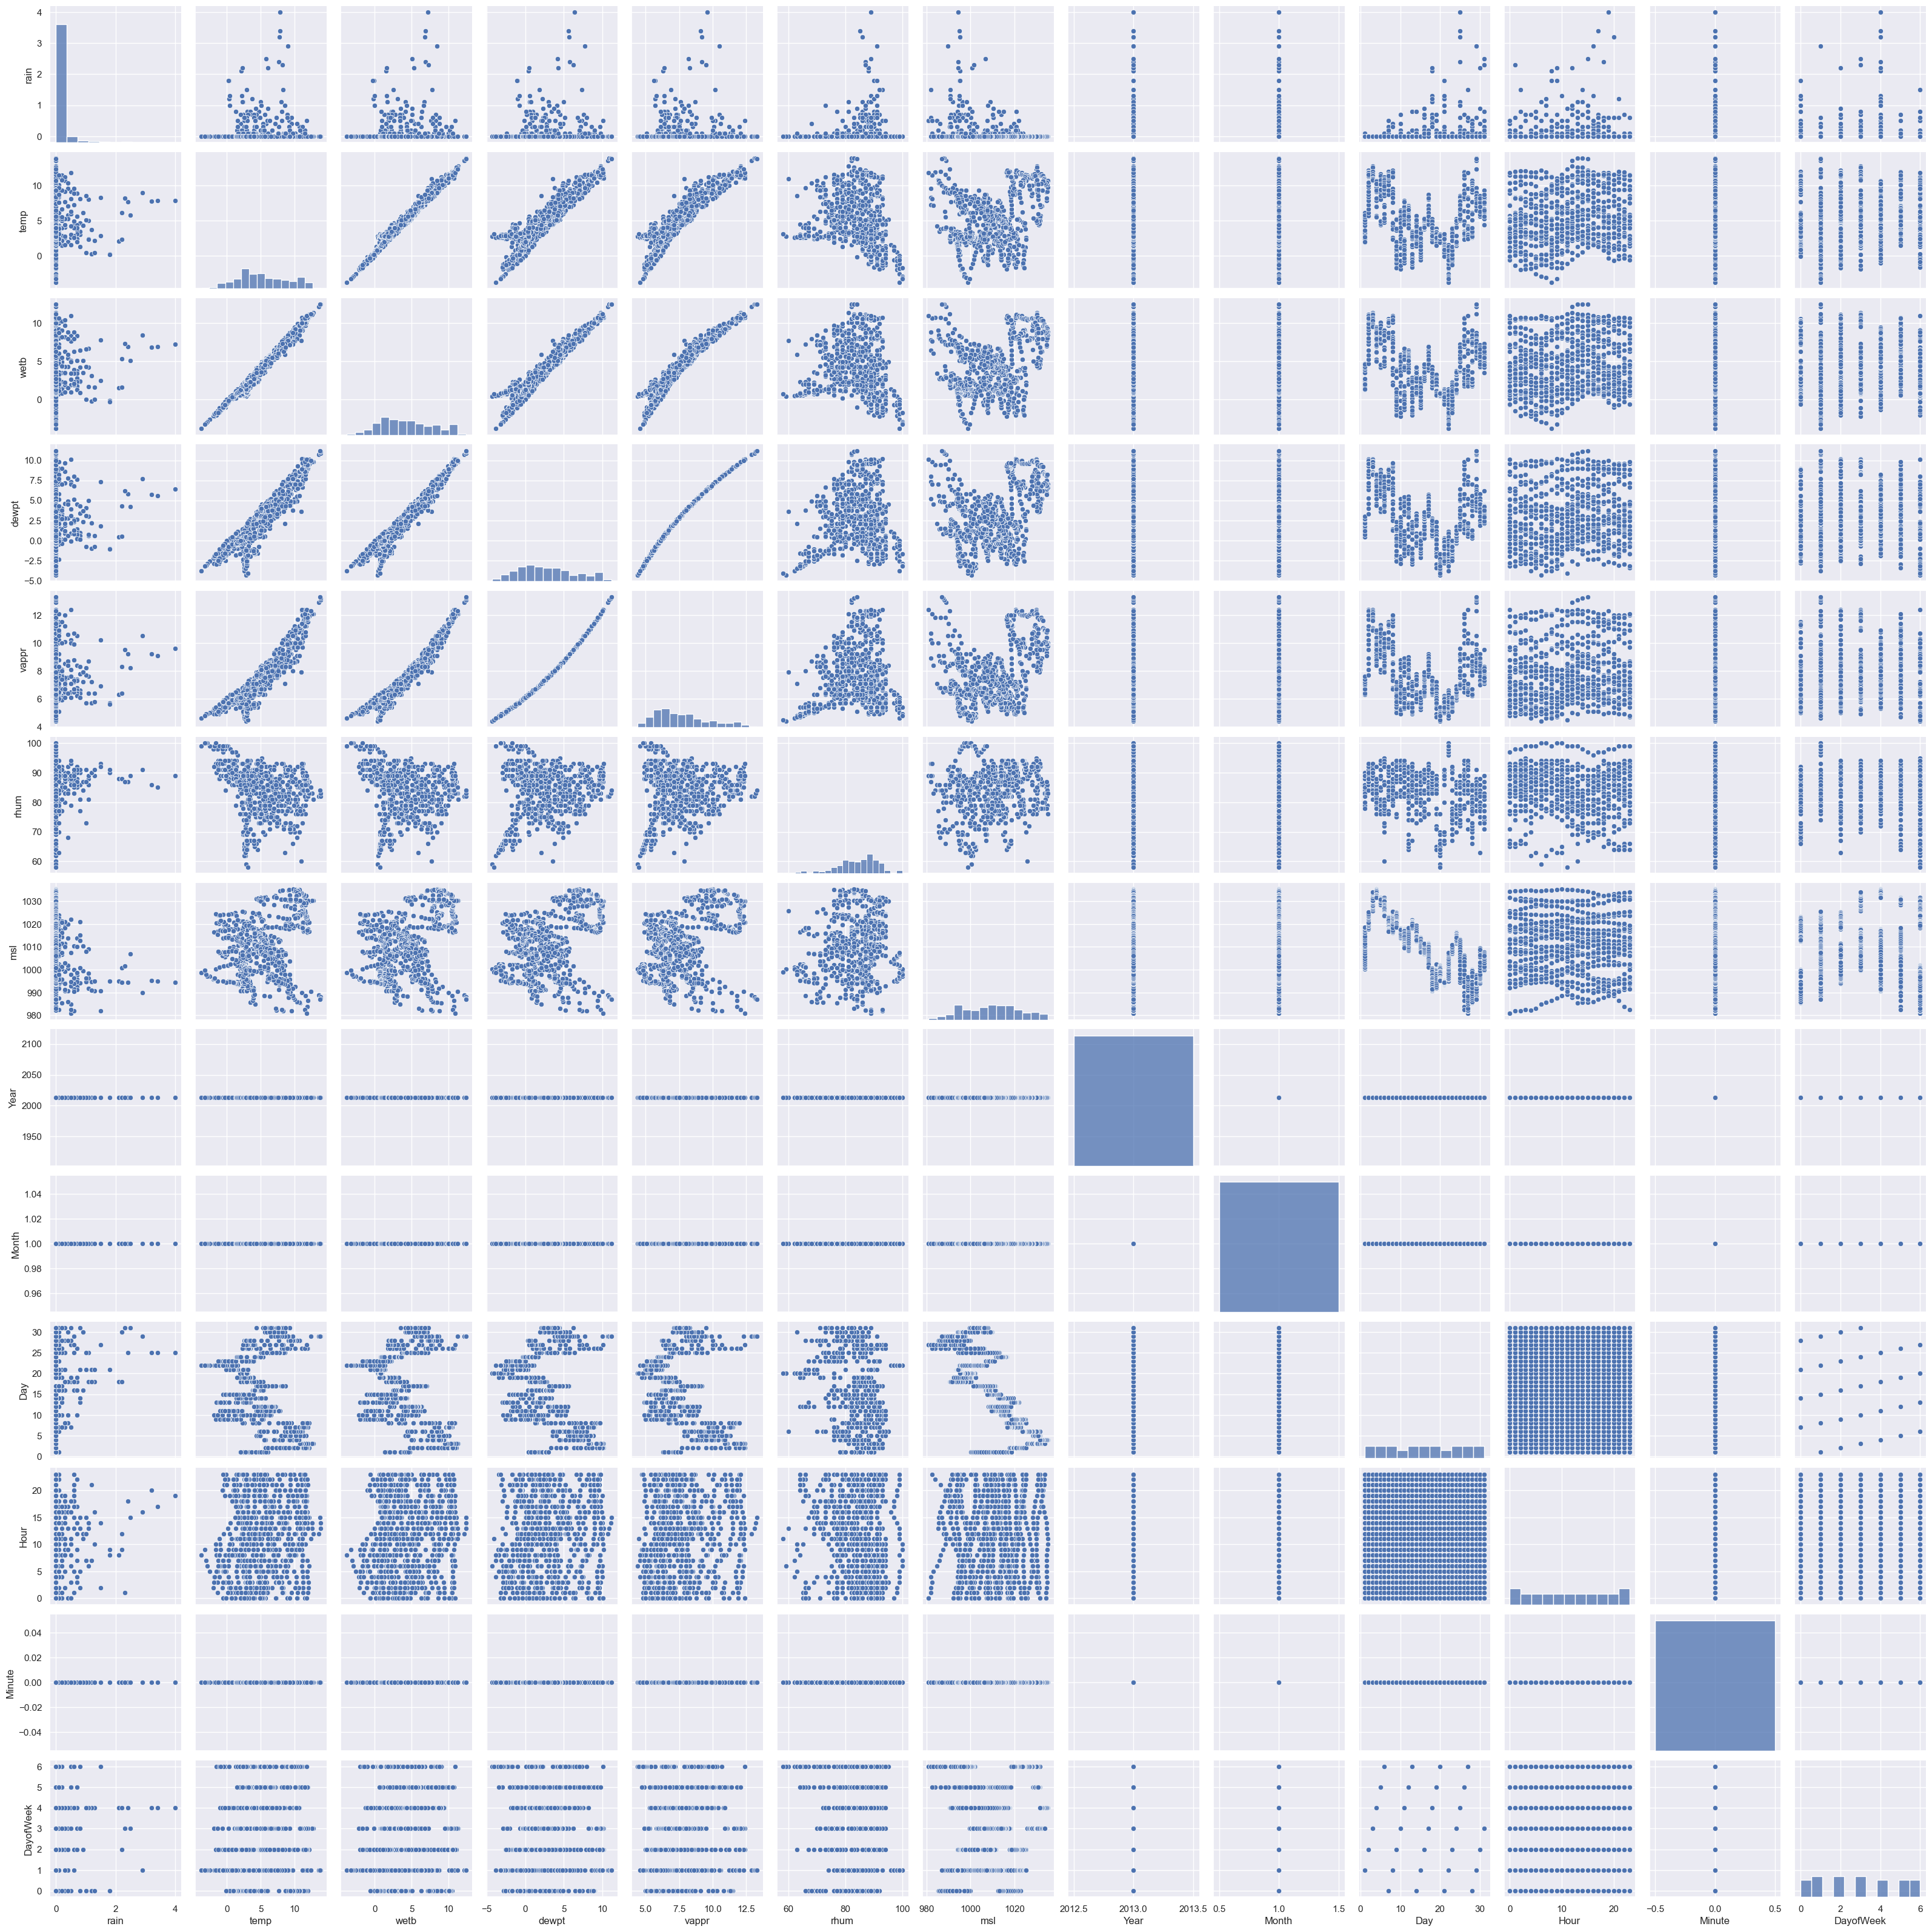

In [34]:
sns.pairplot(Phoenix_wdf)

In [ ]:
c_wd = Phoenix_wdf.corr('pearson', numeric_only=True)

<AxesSubplot:>

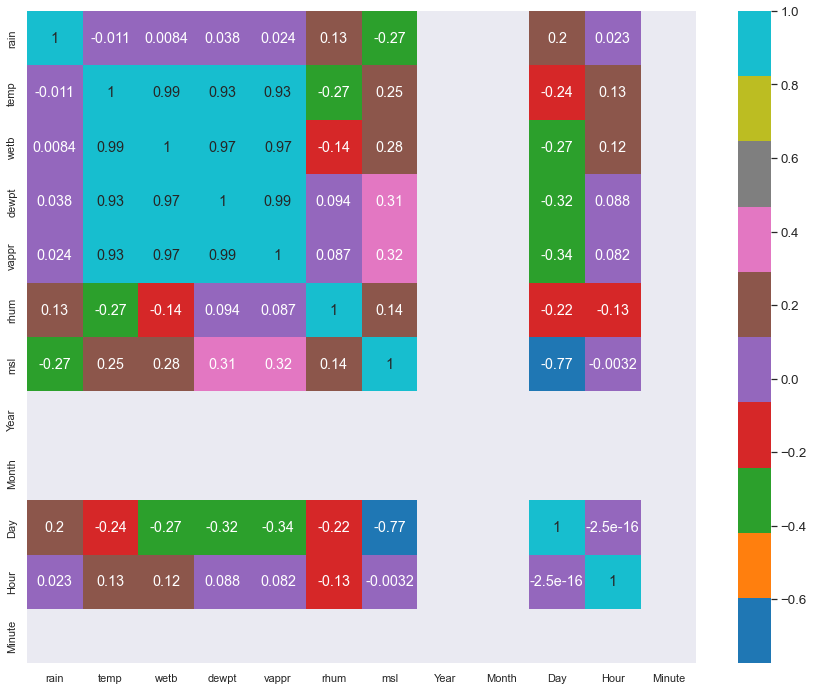

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_wd, cmap="tab10", annot=True)

In [ ]:
#join weather and bus 
df = pd.merge(Phoenix_wdf, df)
df.head()

In [ ]:
c_df = df.corr('pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="tab10", annot=True)

In [ ]:
NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))
sns.regplot(df, x = NumericalColumns, y = 'Delay')

In [ ]:
sns.regplot(df, x = NumericalColumns, y = 'Congestion', logistic = True)

In [ ]:
df.to_parquet('./Data/Bus/CleanedBusData.parquet')